# README
## Biotechnical Energy Efficiency Function (B.E.E.F.)
### The energy-efficiency fungal plastic degradation model
Welcome to our model for calculating optimal conditions for efficient plastic degradation trough fungi. Troughout this model, the word incubation time will be used frequently. This refers to the time (in days) it takes to fully degrade a batch of plastic. This model has been created as part of a research for the course Project 4 at the University of Amsterdam. All the scientifical justification for this model can be found there.

### The model consists of different functions that roughly perform the following tasks:
 - **User input and data preperation:** Converts user-provided CSV files into Python lists.
 - **Fitting:** Fits the data to Gaussian, inverse and linear models and returns their formulas for further calculations.
 - **Equalization:** Adjusts functions for temperature and particle size for accurate model output.
 - **Incubation Time calculations** Calculates the total incubation time for different combinations of temperature and particle size and saves these in a dataframe.
 - **Energy Calculation:** Calculates total energy consumption for combinations of temperature and particle size from the dataframe and adds constant energy costs from the user inputs.
 - **Efficiency Calculation:** Determines energy efficiency by dividing degradation rate by energy cost from the dataframe.
 - **Plotting:** Creates an interactive plot that shows the relationship between energy cost and incubation time, along with the optimal parameters and the efficiency.

For running this model, some fungi-specific data is required. The following user inputs have to be acquired as csv files:
  - a matrix for temperature (°C) against incubation time (days)
  - a matrix for particle size (mm³) against incubation time (days)
  - a matrix with the energy cost (J/mg) for shredding to certain particle sizes (mm³)

Besides this there are also other constants and data that are required for running this model:
  - the size of your bioreactor (m³)
  - the plastic concentration in your bioreactor (mg/mL)
  - the temperature your bioreactor reaches while running after stabilizing its temperature and the wattage this requires. Give this as: 'wattage, temperature reached'
  - the energy cost for potentially running the UV radiation machine (J)
  - potential time dependent extra energy costs that do not fit in another category (W)
  - potential time independent extra energy costs that do not fit in another category (J)

### Running the model
After giving all these datapoints and constants, the model is capable of running the rest of the calculations. To run the entire model, run each of the code parts in order. After running the last code part, the model will ask for the user inputs. If you've given these correctly, the model will start calculating. It will first give intermediary outputs in the form of a plot with the gaussian and inverse fit for temperature and particle size respectivelly and a pandas DataFrame with all the calculated points. The final output will be an interactive bokeh plot showing the relationship between energy cost (MwH) and incubation time (days). The user can hover over every individual point of the plot to see the optimal parameters (temperature and particle size) and the efficiency (degradation rate / energy).

## Notes

 -  The model assumes that all questions are in the context of the Google Colab environment or Jupyter Notebooks.
 - For detailed information on each function, please refer to the comments within the code.
 - The first code block where google drive is imported is not possible in Jupyter Notebook. It is only necessary for accessing your data, which can also be uploaded manually.
 - The plot can be created using both mplcursors and bokeh depending on the environment in which the code is run. The code uses bokeh in case of google colab and mplcursors in all other cases.

## import and install all necessary packages

In [ ]:
# run this code block if you don't have mplcursors and bokeh installed
!pip install mplcursors
!pip install bokeh
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import csv
from scipy import stats
import mplcursors
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

## Processing data
This function processes the user-given files and converts them into python lists.

In [ ]:
def read_csv_to_lists(file_path):
    """
    A function to split the data of the csv into lists.
    Assuming the first column is the incubation time and the second column is the variable.
    """
    with open(file_path, 'r') as file:
        sample = file.read(1024)
        delimiter = csv.Sniffer().sniff(sample).delimiter

    data = pd.read_csv(file_path, delimiter=delimiter, header=0, decimal=',')

    column_names = data.columns.tolist()

    variable = data[column_names[0]].astype(float).tolist()
    incubation_time = data[column_names[1]].astype(float).tolist()

    return variable, incubation_time

## User input

In [ ]:
def get_user_input():
    """Gets user input for the fungal plastic degradation model and returns the
    files for temperature and particle size and the other variables."""

    print("Enter the following things:")

    # Get the csv file for incubation time and temperature and extract the data
    ct_temp_file = input("A CSV file with a matrix of the temperature(°C), plotted against the incubation time of the full degradation (days): ")
    particle_size_standard_value = float(input("Particle size of the polyethylene (mm³) in the water while performing the tests for temperature: "))

    # Get the csv file for incubation time and particle size and extract the data
    ct_part_size_file = input("A CSV file with a matrix of the particle size (mm³), plotted against the incubation time of the full degradation (days) : ")
    temperature_standard_value = float(input("Water temperature (°C) while performing the tests for particle size: "))

    # get the ambient temperature
    ambient_temperature = input("Ambient temperature (°C) while performing all the tests (leave empty for default room temperature (21°C)): ")
    if not ambient_temperature:
        ambient_temperature = 21
        print("No input provided. Using default ambient temperature (room temperature (21°C)).")
    else:
        ambient_temperature = float(ambient_temperature)

    # Get the csv file for energy cost and particle size and extract the data
    energy_part_size_file = input("Enter a CSV file with a matrix of the particle sizes (mm³) against the energy cost for mechanical abrasion to reach that size (J/mg): ")
    if energy_part_size_file:
        try:
            particle_size_MA, energy_cost_MA = read_csv_to_lists(energy_part_size_file)
        except FileNotFoundError:
            print("File not found.")
    else:
        print("No input provided.")

    # ask the user for other constants necessary for the calculations
    plastic_concentration = float(input("Concentration of polyethylene in the water (mg per ml) while performing all the tests: "))
    bioreactor = float(input("Volume of the bioreactor you want to use (m³): "))

    # Get heat energy requirement and convert to tuple of floats
    heat_energy_requirement = input("What is the wattage your bioreactor needs to stay on a certain temperature? (give this seperated by a comma: 'wattage, temperature'):")
    values = heat_energy_requirement.split(',')
    heat_energy_requirement = tuple(float(value.strip()) for value in values)

    # ask remaining questions for energy costs and efficiency
    efficiency_heat_pump = float(input("What is the efficiency of your heat pump? Example: Efficiency is 4 if you need 4 watts of power for every watt of heat.:"))
    uv_energy_cost = input("Energy cost of UV radiation if UV is used, leave empty otherwise (J):")
    if not uv_energy_cost:
        uv_energy_cost = 0
    else:
        uv_energy_cost = float(uv_energy_cost)

    time_dep_extra_energy_costs = input("Time dependent potential extra energy costs that do not fall into another category (W):")
    if not time_dep_extra_energy_costs:
        time_dep_extra_energy_costs = 0
    else:
        time_dep_extra_energy_costs = float(time_dep_extra_energy_costs)

    time_indep_extra_energy_costs = input("Time independent potential extra energy costs that do not fall into another category (J):")
    if not time_indep_extra_energy_costs:
        time_indep_extra_energy_costs = 0
    else:
        time_indep_extra_energy_costs = float(time_indep_extra_energy_costs)

    bokeh = input("Are you running this code in google colab? (y/n)")
    if bokeh.lower() == "y":
        bokeh = True
    else:
        bokeh = False

    # create a dictionary of all variables outside of temperature and particle size
    other_variables = {
        "particle_size_standard_value": particle_size_standard_value,
        "energy_part_size_file": energy_part_size_file,
        "ambient_temperature": ambient_temperature,
        "temperature_standard_value": temperature_standard_value,
        "plastic_concentration": plastic_concentration,
        "bioreactor": bioreactor,
        "heat_energy_requirement": heat_energy_requirement,
        "efficiency_heat_pump": efficiency_heat_pump,
        "particle_size_MA": particle_size_MA,
        "energy_cost_MA": energy_cost_MA,
        "uv_energy_cost": uv_energy_cost,
        "time_dep_extra_energy_costs": time_dep_extra_energy_costs,
        "time_indep_extra_energy_costs": time_indep_extra_energy_costs,
        "bokeh": bokeh
    }

    return ct_temp_file, ct_part_size_file, other_variables

## Classes for a gaussian, linear and inverse function

In [ ]:
class gaussian:
  """ A class that represents a Gaussian distribution """

  def __init__(self, name: str, mu: float, sigma: float, other_variables: dict[str:float], amplitude:float = 1, range:tuple = (0,0)) -> None:
    self.name = name
    self.mu = mu
    self.sigma = sigma
    self.other_variables = other_variables # other_variables zijn de standaardwaarden
    self.amplitude = amplitude
    if range != (0,0):
      self.range = range
    else:
      self.range = (self.mu - 4 * self.sigma, self.mu + 4 * self.sigma)


  def evaluate(self, x: float) -> float:
    """ A standard Gaussian function with mu as the mean and sigma as the standard
    deviation. Mu and sigma will be derived from input data
    """
    return self.amplitude * np.exp(-np.power(x - self.mu, 2.) / (2 * np.power(self.sigma, 2.)))

  def change_amplitude(self, factor: float) -> None:
    """ Changing the amplitute to equalize the functions. """
    self.amplitude *= factor

  def ratio_from_max(self, point: float) -> float:
    """Calculate the difference from the maximum for a different Gaussiam"""
    optimum = self.evaluate(self.mu)
    point = self.evaluate(point)
    return point / optimum

  def get_amplitude(self) -> float:
    """Returns the parameters of the Gaussian distribution as a dictionary."""
    return self.amplitude

  def get_other_variables(self) -> dict:
    """Returns the parameters of the Gaussian distribution as a dictionary."""
    return self.other_variables

  def get_name(self) -> str:
    """Returns the name of the Gaussian distribution."""
    return self.name

  def get_range(self) -> tuple:
    """Returns the range of the Gaussian distribution."""
    return self.range

  def get_max(self) -> float:
    """Returns the maximum of the Gaussian distribution."""
    return self.evaluate(self.mu)

  def plot(self, start = None, end = None, num_points = 100,
           title = "Temperature vs. Degradation Rate", xlabel = "Temperature (°C)",
           ylabel = "Degradation Rate (mg/day)", label = "Gaussian fit", color = "r") -> None:

    """ A function that plots the Gaussian distribution """

    # Gives an approximate range for the plot if it isn't given
    if start == None:
      start = self.mu - 4 * self.sigma
    if end == None:
      end = self.mu + 4 * self.sigma

    # Plots the gaussian distribution
    x_values = np.linspace(start, end, num_points)
    y_values = self.evaluate(x_values)
    plt.plot(x_values, y_values, color = color, label = label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.show()

class linear:
  """ A class that represents a Gaussian distribution """

  def __init__(self, name: str, slope: float, intercept: float, min: float, other_variables: dict[str:float], range:tuple = (0,0)) -> None:
      self.name = name
      self.slope = slope
      self.intercept = intercept
      self.min = min
      self.other_variables = other_variables # other_variables zijn de standaardwaarden
      if range != (0,0):
          self.range = range
      else:
          self.range = (intercept, 100)


  def evaluate(self, x: float) -> float:
      """ A standard linear function with a slope and a y intercept"""
      return (self.slope * x + self.intercept)

  def change_intercept(self, factor: float) -> None:
      """ Changing the amplitute to equalize the functions. """
      self.intercept *= factor

  def ratio_from_max(self, point: float) -> float:
      """Calculate the difference from the maximum for a point on the linear function"""
      optimum = self.evaluate(self.min)
      point = self.evaluate(point)
      return point / optimum

  def get_intercept(self) -> float:
      """Returns the y intercept of the linear function"""
      return self.intercept

  def get_other_variables(self) -> dict:
      """Returns the parameters of the linear function as a dictionary."""
      return self.other_variables

  def get_name(self) -> str:
      """Returns the name of the linear distribution."""
      return self.name

  def get_range(self) -> tuple:
      """Returns the range of the linear distribution."""
      return self.range

  def get_min(self) -> float:
      """Returns the minimum of the linear distribution."""
      return self.min

  def plot(self, start = None, end = None, num_points = 100,
            title = "Particle Size vs. energy cost", xlabel = "Particle size (mm³)",
            ylabel = "Energy cost (Joule)",label = "Linear regression", color = "r") -> None:
      """ A function that plots the linear function """

      # Gives an approximate range for the plot if it isn't given
      if start == None:
        start = self.min
      if end == None:
        end = self.min * 10

      # Plots the gaussian distribution
      x_values = np.linspace(start, end, num_points)
      y_values = self.evaluate(x_values)
      plt.plot(x_values, y_values, color = color, label = label)
      plt.ylabel(ylabel)
      plt.xlabel(xlabel)
      plt.title(title)
      plt.legend()
      plt.show()

class inverse:
    """A class that represents an inverse relationship (1/x)."""

    def __init__(self, name: str, a:float, min_val: float, other_variables: dict[str:float], range:tuple = (0,0)) -> None:
        self.name = name
        self.a = a
        self.min_val = min_val  # Minimum value for x to avoid division by zero
        self.other_variables = other_variables
        if range != (0,0):
          self.range = range
        else:
          self.range = (self.min_val, self.min_val * 10) # Default range

    def evaluate(self, x: float) -> float:
        """Evaluates the inverse function 1/x."""
        return self.a / x

    def ratio_from_max(self, point: float) -> float:
        """Calculate the difference from the maximum for a point on the inverse function."""
        optimum = self.evaluate(self.min_val)
        point = self.evaluate(point)
        return point / optimum

    def change_amplitude(self, factor: float) -> None:
        """Changes the amplitude of the inverse function."""
        self.a *= factor

    def get_a(self) -> float:
        """Returns the amplitude of the inverse function."""
        return self.a

    def get_other_variables(self) -> dict:
        """Returns the parameters of the inverse function as a dictionary."""
        return self.other_variables

    def get_name(self) -> str:
        """Returns the name of the inverse function."""
        return self.name

    def get_range(self) -> tuple:
        """Returns the range of the inverse function."""
        return self.range

    def get_min(self) -> float:
        """Returns the minimum allowed value of the inverse function."""
        return self.min_val

    def get_max(self) -> float:
        """Returns the maximum possible degradation rate"""
        return self.evaluate(self.min_val)

    def plot(self, start=None, end=None, num_points=100,
             title="Particle size vs. average degradation rate",
             xlabel="Particle size (mm³)", ylabel="Average degradation rate (mg/day)",
             label="Inverse fit", color="r") -> None:
        """Plots the inverse function."""
        if start is None:
            start = self.min_val
        if end is None:
            end = self.min_val * 5

        x_values = np.linspace(start, end, num_points)
        y_values = self.evaluate(x_values)
        plt.plot(x_values, y_values, color=color, label=label)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.legend()
        plt.show()

## Fitting temperature

In [ ]:
# fits the raw data to a gaussian for the degradation rate

def incubation_time_to_rate(incubation_times: list, other_variables: dict) -> list:
    """ A function that converts a list of incubation times to the degradation rates.
    """
    # Calculates the amound of degradated plastic
    plastic_concentration = other_variables["plastic_concentration"]
    bioreactor = other_variables["bioreactor"]
    plastic_amount_mg = plastic_concentration * bioreactor * 1_000_000

    # return the degradation rates
    return [plastic_amount_mg / incubation_time for incubation_time in incubation_times]

def fit_temperature(temperatures: list[float], incubation_times: list[float], other_variables: dict):
    """ Changes the incubation times to degradation rates and fits them as a gaussian
    over temperature.
    """

    # change incubation time to degradation rate and make an initial guess
    avg_degradation_rates = incubation_time_to_rate(incubation_times, other_variables)
    estimated_amp = max(avg_degradation_rates)
    estimated_mu = temperatures[avg_degradation_rates.index(estimated_amp)]
    estimated_sigma = np.std(temperatures)
    initial_guess = [estimated_amp, estimated_mu, estimated_sigma]

    # Function to pass to curve_fit
    def gaussian_func(x, amp, mu, sigma):
        return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

    # fit the curve and extract the parameters
    popt, pcov = curve_fit(gaussian_func, temperatures, avg_degradation_rates, p0=initial_guess, maxfev=10000)
    amp, mu, sigma = popt

    # Implement data in gaussian class
    gaussian_temp = gaussian(name="Temperature", mu=mu, sigma=sigma, other_variables=other_variables,
                             amplitude=amp, range=(min(temperatures), max(temperatures)))
    gaussian_temp.plot()

    return gaussian_temp

## Fitting particle sizes

In [ ]:
def fit_particle_size(particle_size: list[float], incubation_times: list[float], other_variables: dict) -> inverse:
    """ Changes the incubation times to degradation rates and fits them as a gaussian
    over temperature.
    """

    # change incubation time to degradation rate and make an initial guess
    avg_degradation_rates = incubation_time_to_rate(incubation_times, other_variables)

    # an inverse function to use curve_fit on
    def func_1x(x, a):
        return a * 1/x

    # fit the data to the inverse function
    popt, pcov = curve_fit(func_1x, particle_size, avg_degradation_rates)
    a = popt

    # use the inverse class for the inverse fit
    inverse_particle_size = inverse(name="Particle Size", a=a, min_val=22.5,
                                    other_variables=other_variables, range=(22.5,  22.5*10))

    # plot the inverse function
    inverse_particle_size.plot()

    return inverse_particle_size

## Equalizing the functions

In [ ]:
def amount_of_plastic(other_variables: dict) -> float:
    """ A function that calculates the amount of plastic in the bioreactor """

    plastic_concentration = other_variables["plastic_concentration"]
    bioreactor = other_variables["bioreactor"]

    # Convert bioreactor volume to ml
    bioreactor_ml = bioreactor * 1_000_000  # 1 m^3 = 1,000,000 ml

    # Total plastic amount in mg
    total_plastic_mg = plastic_concentration * bioreactor_ml

    return total_plastic_mg

def equalize_functions(temperature:gaussian, particle_size: inverse, other_variables) -> None:
    """
    Optimalizes both temperature and particle size to equalize the functions.
    """

    # get the information for the standard values
    particle_size_standard_value = other_variables["particle_size_standard_value"]
    temperature_standard_value = other_variables["temperature_standard_value"]

    # optimalize temperature and particle size
    temperature.change_amplitude(particle_size.ratio_from_max(particle_size_standard_value))
    particle_size.change_amplitude(temperature.ratio_from_max(temperature_standard_value))

## Creating matrix and dataframe for incubation time

In [ ]:
def get_max_degradation_rate(temperature:gaussian, particle_size: inverse) -> float:
    "Gets the maximum possible degradation rate for the optimalized variables"
    maxes = [temperature.get_max(), particle_size.get_max()]
    return max(maxes)

def get_incubation_data(temperature:gaussian, particle_size: inverse, other_variables):
    """
    Creates a Pandas DataFrame and a NumPy matrix representing the degradation rate
    for all possible combinations of variables within specified ranges.
    """

    # Get the total amount of plastic
    total_plastic_mg = amount_of_plastic(other_variables)

    # Get variable names
    function_list = [temperature, particle_size]
    variable_names = [function.get_name() for function in function_list]
    num_variables = len(variable_names)

    # Create meshgrid for all variable combinations
    meshgrid_args = [np.linspace(*function.get_range(), num=200) for function in function_list]
    meshgrid = np.meshgrid(*meshgrid_args, indexing='ij')

    # Create empty incubation data containers for the DataFrame
    data = {name: [] for name in variable_names}
    incubation_times = []

    # Iterate through all combinations and calculate degradation rate
    for index in np.ndindex(meshgrid[0].shape):
        values = {variable_names[i]: meshgrid[i][index] for i in range(num_variables)}

        # start with the maximum degradation rate and decrease with the ratio_from_max
        degradation_rate = get_max_degradation_rate(temperature, particle_size)

        for function in function_list:
            if function.name in values:

                # Calulate the combined degradation rate and change back to incubation time
                degradation_rate *= function.ratio_from_max(values[function.name])

        # Calculate the incubation time and store it
        incubation_time = float(total_plastic_mg / degradation_rate)
        incubation_times.append(incubation_time)

        # Store the variables in the dataframe
        for name in variable_names:
            data[name].append(values[name])

    # Create the Pandas DataFrame
    incubation_df = pd.DataFrame(data)
    incubation_df['incubation_time'] = incubation_times

    # Return both the DataFrame and the matrix
    return incubation_df

## Fitting particle size against energy cost

In [ ]:
def particle_size_energy(other_variables: dict) -> linear:
    """
    Plots a linear regression over the energy costs for mechanical abrasion and
    the resulting particle size using the linear class. The result is given in Joule.
    """

    # Extract particle_size_MA and energy_cost_MA
    particle_size_MA = other_variables["particle_size_MA"]
    energy_cost_MA_W = other_variables["energy_cost_MA"]

    # Change energy cost from J/mg to Joules
    total_plastic_mg = amount_of_plastic(other_variables)
    energy_cost_MA_J = [energy_cost * total_plastic_mg for energy_cost in energy_cost_MA_W]

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(particle_size_MA, energy_cost_MA_J)

    # Create linear object
    particle_size_energy = linear(name="Linear Regression", slope=slope, intercept=intercept,
                        min=min(particle_size_MA), other_variables={},
                        range=(min(particle_size_MA), max(particle_size_MA)))

    return particle_size_energy

## Calculating total energy costs

In [ ]:
def energy_heating_up_to_temp(temp: float, other_variables: dict) -> float:
    """ A function that calculates the energy cost in kWh for raising the temperature
    of a vat of water for a given start temperature and volume of water in liters
    using P = m x c x ∆t x 1/3600. The result is given in Joule. """

    # Variables for the equation
    start_temp = other_variables["ambient_temperature"]
    bioreactor = other_variables["bioreactor"]
    efficiency = other_variables["efficiency_heat_pump"]
    end_temp = temp
    spec_heat = 4.187*1000
    density = 998

    # Using the equation
    mass = density * bioreactor
    diff_temp = end_temp - start_temp
    energy_cost = diff_temp * spec_heat * mass * (1/3600)

    return energy_cost * efficiency

def energy_staying_on_temp(temp: float, incubation_time: float, other_variables: dict) -> float:
    """ A function that calculates the heat transfer coefficient for the specific
    bioreactor while the flowing mechanism is active, which can be used to calculate
    the energy cost for keeping the bioreactor at a certain temperature. This energy
    cost is given in Joule.
    """

    # acquiring the necessary variables for the formula
    bioreactor = other_variables["bioreactor"]
    heat_energy_requirement = other_variables["heat_energy_requirement"]
    ambient_temperature = other_variables["ambient_temperature"]
    efficiency_heat_pump = other_variables["efficiency_heat_pump"]
    density = 998
    spec_heat = 4.187*1000
    mass = density * bioreactor
    wattage, test_temperature = heat_energy_requirement[0], heat_energy_requirement[1]
    test_diff_temp = test_temperature - ambient_temperature

    # calculating the heat transfer coefficient
    heat_transfer_coefficient = - (wattage / (mass * spec_heat * (test_diff_temp) * efficiency_heat_pump))

    # calculating the energy cost for a certain temperature in Joule
    diff_temp = temp - ambient_temperature
    energy_cost = - heat_transfer_coefficient * mass * spec_heat * diff_temp
    energy_cost *= (incubation_time*24*60*60) * efficiency_heat_pump

    return energy_cost


def energy_MA_part_size(particle_size: float, other_variables: dict) -> float:
    """Calculates the amount of energy required to use mechanical abrasion for
    reduction of particle size. """

    part_size_energy = particle_size_energy(other_variables)
    energy_cost = part_size_energy.evaluate(particle_size)
    if energy_cost <= 0:
        energy_cost = 0

    return energy_cost

def energy_flow(incubation_time: float, other_variables: dict) -> float:
    """Calculates the amount of energy required to use a bubbler which is required
    for oxidizing and flowing the bioreactor using a fitted formula from data. """

    bioreactor = other_variables["bioreactor"]
    energy_MwH_year = 0.0998 * bioreactor - 149.96
    energy_MwH = energy_MwH_year * (incubation_time / 365)
    energy_J = energy_MwH * (3.6 * 10**9)
    if energy_J <= 0:
        energy_J = 0

    return energy_J

def calculate_total_energy(incubation_time: float, temp_water: float,
                           particle_size: float, other_variables: dict) -> float:
    """Calculates the total energy cost for the combined variables and constants.
    Returns the energy costs in MwH"""

    # Extract all the constant energies
    uv_energy_cost = other_variables["uv_energy_cost"]
    time_dep_extra_energy_costs = other_variables["time_dep_extra_energy_costs"]
    time_indep_extra_energy_costs = other_variables["time_indep_extra_energy_costs"]

    # Convert the constant energy from Watt to Joule and add them to the total energy
    total_energy = 1 + time_indep_extra_energy_costs + uv_energy_cost + (time_dep_extra_energy_costs)*incubation_time*24*60*60

    # Add the energy from the variables
    total_energy += energy_heating_up_to_temp(temp_water, other_variables)
    total_energy += energy_staying_on_temp(temp_water, incubation_time, other_variables)
    total_energy += energy_MA_part_size(particle_size, other_variables)
    total_energy += energy_flow(incubation_time, other_variables)
    total_energy /= (3.6*10**9)

    return total_energy

### Creating matrix and dataframe for the incubation time + energy costs

In [ ]:
def get_energy_data(temperature:gaussian, particle_size: inverse, other_variables: dict):
    """
    Adds an energy dimension to the DataFrame and degradation matrix by calculating
    the added energy using the calculate_total_energy function.
    """

    # Get variable names
    function_list = [temperature, particle_size]
    variable_names = [function.get_name() for function in function_list]

    # Get the incubation data and create new DataFrame
    incubation_df = get_incubation_data(temperature, particle_size, other_variables)
    incubation_energy_df = incubation_df.copy()

    # Add energy column to DataFrame
    incubation_energy_df['energy_cost'] = incubation_energy_df.apply(

        # Uses Lambda to apply calculate_total_energy over every row
        lambda row: calculate_total_energy(
            row['incubation_time'],   # Incubation time
            row[variable_names[0]],   # Temperature
            row[variable_names[1]],   # Particle size
            other_variables
        ),
        axis=1
    )

    return incubation_energy_df



## Creating matrix and dataframe for efficiency

In [ ]:
def calculate_energy_efficiency(temperature:gaussian, particle_size: inverse, other_variables: dict):
    """
    Adds an energy efficiency column to the DataFrame and creates an energy efficiency matrix.
    The energy efficiency is calculated by dividing the degradation rate by the energy cost.
    """

    # Extracting the necessary dataframe and matrices and creating new DataFrame
    incubation_energy_df = get_energy_data(temperature, particle_size, other_variables)
    efficiency_df = incubation_energy_df.copy()

    # Calculate degradation rate
    total_plastic_mg = amount_of_plastic(other_variables)
    efficiency_df['avg_degradation_rate'] = total_plastic_mg / efficiency_df['incubation_time']

    # Calculate energy efficiency for DataFrame, handling zero energy values
    efficiency_df['energy_efficiency'] = np.where(
        incubation_energy_df['energy_cost'] != 0,
        efficiency_df['avg_degradation_rate'] / incubation_energy_df['energy_cost'] * efficiency_df['incubation_time'],
        0
    )

    print(efficiency_df)

    return efficiency_df

## Optimalizing for efficiency and creating interactive plot

In [ ]:
def plot_energy_efficiency_mplcursors(temperature: gaussian, particle_size: inverse, other_variables: dict):
    """ Calculates the energy efficiency for a range of energy costs and plots the
    results using mplcursors. Hovering over the plot points displays the optimal
    parameters for that energy cost. mplcursors doesn't work in google colab. Use
    the function plot_energy_efficiency_bokeh in google colab.
    """
    # Get the dataframe and matrix
    efficiency_df = calculate_energy_efficiency(temperature, particle_size, other_variables)

    # Set the range of energies. Change max_energy if the range is incorrect
    min_energy = np.min(efficiency_df["energy_cost"])
    max_energy = min_energy * 3.5
    energies = np.linspace(min_energy, max_energy, num = 100)

    # Create an empty dictionary to store the optimal parameters for each energy point
    optimal_parameters = {}
    lowest_incubation = []

    # Get highest efficiency for each energy point
    for energy in energies:

        # Select row with highest efficiency within energy range
        energy_df = efficiency_df[efficiency_df['energy_cost'] <= energy]

        # Check to see if energy_df is empty before proceeding
        if energy_df.empty:

            # if it is empty append a nan to the incubation time and continue to next loop
            lowest_incubation.append(float('nan'))
            continue

        sorted_energy_df = energy_df.sort_values(by='incubation_time', ascending=True)
        optimal_row = sorted_energy_df.iloc[0]  # select highest efficiency
        lowest_incubation.append(optimal_row['incubation_time'])

        # Store optimal parameters from optimal_row in the dictionary
        optimal_parameters[energy] = optimal_row.to_dict()

    # Plotting the energy-efficiency plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed
    line, = ax.plot(energies, lowest_incubation, marker='o', linestyle='-')  # Store line object
    ax.set_xlabel('Energy Cost (MwH)')
    ax.set_ylabel('Incubation Time (days)')
    ax.set_title('Energy Efficiency Optimization')
    ax.grid(True)

    # Add hover functionality to display parameter data on the plot
    cursor = mplcursors.cursor(line, hover=True)
    @cursor.connect("add")

    # Shows parameter data while hovering over line
    def on_add(sel):
        index = sel.target.index
        energy = energies[index]
        optimal_params = optimal_parameters[energy]

        # Include the first two parameters and efficiency (unrounded)
        parameters = {
            key: value if key == 'efficiency' else round(value, 2) if isinstance(value, (int, float)) else value
            for key, value in list(optimal_params.items())[:2] + [list(optimal_params.items())[-1]]
        }

        sel.annotation.set_text(f"Energy: {energy:.2f}\nOptimal Parameters:\n{parameters}")

    plt.show()

    # Finding the most efficient point
    max_efficiency_index = np.argmax(efficiency_df['energy_efficiency'])
    most_efficient_row = efficiency_df.iloc[max_efficiency_index]
    energy = round(most_efficient_row['energy_cost'], 2)
    incubation_time = round(most_efficient_row['incubation_time'], 2)
    efficiency = round(most_efficient_row['energy_efficiency'], 2)
    print(f"the most efficient point is at: {energy}, {incubation_time} with an efficiency of {efficiency}")

def plot_energy_efficiency_bokeh(temperature: gaussian, particle_size: inverse, other_variables: dict):
    """ Calculates the energy efficiency for a range of energy costs and plots the
    results using bokeh. Hovering over the plot points displays the optimal
    parameters for that energy cost.
    """

    # Get the dataframe and matrix
    efficiency_df = calculate_energy_efficiency(temperature, particle_size, other_variables)

    # Set the range of energies. Change max_energy if the range is incorrect
    min_energy = np.min(efficiency_df["energy_cost"])
    max_energy = min_energy * 3.5
    energies = np.linspace(min_energy, max_energy, num=100)

    # Create an empty dictionary to store the optimal parameters for each energy point
    optimal_parameters = {}
    lowest_incubation = []

    # Get highest efficiency for each energy point
    for energy in energies:

        # Select row with highest efficiency within energy range
        energy_df = efficiency_df[efficiency_df['energy_cost'] <= energy]

        # Check to see if energy_df is empty before proceeding
        if energy_df.empty:

            # if it is empty append nan to the incubation time and continue to next loop
            lowest_incubation.append(float('nan'))
            continue

        sorted_energy_df = energy_df.sort_values(by='incubation_time', ascending=True)
        optimal_row = sorted_energy_df.iloc[0]  # select highest efficiency
        lowest_incubation.append(optimal_row['incubation_time'])

        # Store optimal parameters from optimal_row in the dictionary
        optimal_parameters[energy] = optimal_row.to_dict()

    # Include the first two parameters and efficiency (unrounded) in rounded_params
    rounded_params = [
        {key: value if key == 'efficiency' else round(value, 2) if isinstance(value, (int, float)) else value
        for key, value in list(params.items())[:2] + [list(params.items())[-1]]}
        for params in optimal_parameters.values()
    ]

    # Create a ColumnDataSource for Bokeh
    source = ColumnDataSource(data=dict(
        energy=energies,
        incubation=lowest_incubation,
        params=[str(param) for param in rounded_params]  # Convert rounded params to strings
    ))

    # Create a Bokeh plot
    p = figure(
        title="Energy Efficiency Optimization",
        x_axis_label="Energy Cost (MwH)",
        y_axis_label="Incubation Time (days)",
        tools="pan,wheel_zoom,box_zoom,reset,save",  # Add interactive tools
        tooltips=[("Energy", "@energy{0.2f}"), ("Optimal Parameters", "@params")]  # Define tooltips
    )

    # Add a line to the plot
    p.line(x="energy", y="incubation", source=source)
    p.circle(x="energy", y="incubation", source=source, size=8)  # Add circles for better hover

    # Enable output in the notebook
    output_notebook()

    # Show the plot
    show(p)

    # Finding the most efficient point
    max_efficiency_index = np.argmax(efficiency_df['energy_efficiency'])
    most_efficient_row = efficiency_df.iloc[max_efficiency_index]
    energy = round(most_efficient_row['energy_cost'], 2)
    incubation_time = round(most_efficient_row['incubation_time'], 2)
    efficiency = round(most_efficient_row['energy_efficiency'], 2)
    print(f"the most efficient point is at: {energy}, {incubation_time} with an efficiency of {efficiency}")


## A function for running the model

In [ ]:
def run_model():
    """
    This function runs the entire fungal plastic degradation model and runs all
    the functions.
    """

    # Get the user input
    ct_temp_file, ct_part_size_file, other_variables = get_user_input()

    # Try to open the files
    try:
        with open(ct_temp_file, 'r') as file:
            print("File successfully opened!")
        with open(ct_part_size_file, 'r') as file:
            print("File successfully opened!")

    except FileNotFoundError:
        print("File not found. Please check the path and try again.")

    # Fit temperature and particle size data to the models
    temperatures, incubation_times_temp = read_csv_to_lists(ct_temp_file)
    temp_gaussian = fit_temperature(temperatures, incubation_times_temp, other_variables)

    particle_sizes, incubation_times_part_size = read_csv_to_lists(ct_part_size_file)
    particle_size_inverse = fit_particle_size(particle_sizes, incubation_times_part_size, other_variables)

    # Equalize the temperature and particle size functions.
    equalize_functions(temp_gaussian, particle_size_inverse, other_variables)

    # plot the interactible graph trough bokeh or mplcursors
    bokeh = other_variables["bokeh"]
    if bokeh:
        plot_energy_efficiency_bokeh(temp_gaussian, particle_size_inverse, other_variables)
    else:
        plot_energy_efficiency_mplcursors(temp_gaussian, particle_size_inverse, other_variables)


    # Print a message indicating the completion of the model run
    print("Model run completed. Check the plots for results.")

## Running the model

Enter the following things:
A CSV file with a matrix of the temperature(°C), plotted against the incubation time of the full degradation (days): /content/ct_temp_dummy - ct_temp_dummy (4).csv
Particle size of the polyethylene (mm³) in the water while performing the tests for temperature: 25
A CSV file with a matrix of the particle size (mm³), plotted against the incubation time of the full degradation (days) : /content/ct_particle_size - Default energy for particle size (3).csv
Water temperature (°C) while performing the tests for particle size: 58
Ambient temperature (°C) while performing all the tests (leave empty for default room temperature (21°C)): 
No input provided. Using default ambient temperature (room temperature (21°C)).
Enter a CSV file with a matrix of the particle sizes (mm³) against the energy cost for mechanical abrasion to reach that size (J/mg): /content/energy_part_size - Blad1.csv
Concentration of polyethylene in the water (mg per ml) while performing all the tests

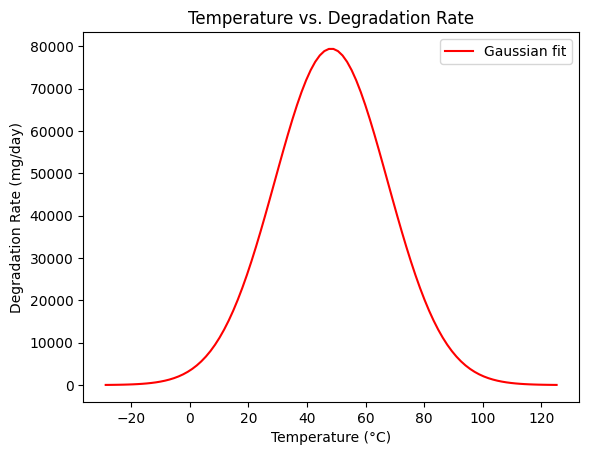

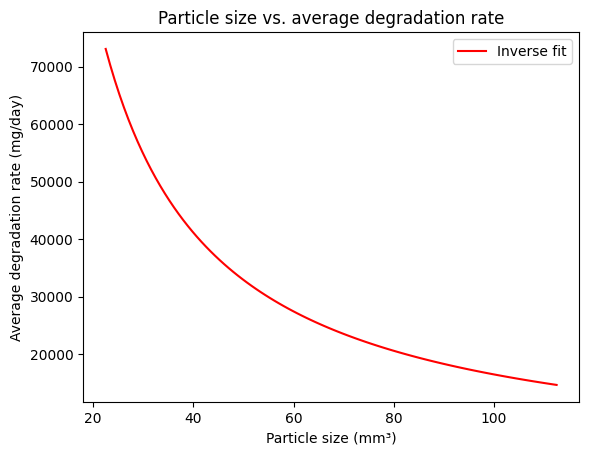

<ipython-input-10-7e0e5ee879d5>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  incubation_time = float(total_plastic_mg / degradation_rate)


       Temperature  Particle Size  incubation_time   energy_cost  \
0             25.0      22.500000      1448.456846    120.831202   
1             25.0      23.517588      1513.964944    126.294920   
2             25.0      24.535176      1579.473043    131.758637   
3             25.0      25.552764      1644.981141    137.222355   
4             25.0      26.570352      1710.489240    142.686073   
...            ...            ...              ...           ...   
39995         70.0     220.929648     13016.476285  13300.415340   
39996         70.0     221.947236     13076.429348  13361.676180   
39997         70.0     222.964824     13136.382412  13422.937020   
39998         70.0     223.982412     13196.335476  13484.197860   
39999         70.0     225.000000     13256.288540  13545.458700   

       avg_degradation_rate  energy_efficiency  
0              34519.495800      413800.402082  
1              33025.863770      395898.743096  
2              31656.127485      379

the most efficient point is at: 120.83, 1448.46 with an efficiency of 413800.4
Model run completed. Check the plots for results.


In [ ]:
run_model()